## Computing PSD with Welch's 
Website used for reference:
[Compute the average bandpower of an EEG signal](https://raphaelvallat.com/bandpower.html)

In [3]:
import pickle
import numpy as np
import pandas as pd

# load all raw data from DEAP dataset
x = pickle.load(open('data_preprocessed_python/s01.dat', 'rb'), encoding='latin1')
data = x['data']
labels = x['labels']

relevant_channels = data[:, :32, :]
relevant_labels = labels[:, :2]

print("Data shape after selecting first 32 channels:", relevant_channels.shape)
print("Labels shape:", relevant_labels.shape)


Data shape after selecting first 32 channels: (40, 32, 8064)
Labels shape: (40, 2)


In [5]:
# Organizing data into dataframes
labels_df = pd.DataFrame(relevant_labels, columns=['valence', 'arousal'])

trials_dfs = []
for i in range(40):
    eeg_df = pd.DataFrame(relevant_channels[i, :, :])
    trials_dfs.append(eeg_df)

Data shape: (32, 8064)
Frequencies shape: (1025,)
PSD shape: (32, 1025)


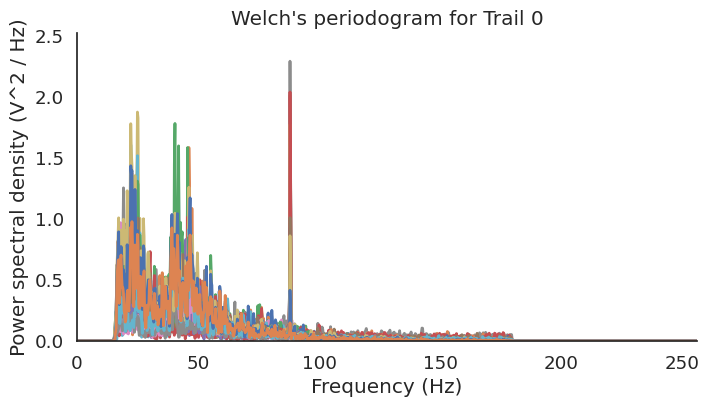

In [ ]:
from scipy import signal
import seaborn as sns
import matplotlib.pyplot as plt

window_length = 4 * 512 # seconds * sample frequency
                        # seconds = two cycles of lowest frequency = 2/0.5 = 4
frequencies, psd = signal.welch(trials_dfs[0], 512, nperseg=window_length)

# example of using Welch's method to view PSD for all frequencies in first trial, first subject
print("Data shape:", trials_dfs[0].shape)
print("Frequencies shape:", frequencies.shape)
print("PSD shape:", psd.shape)
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
for channel_psd in psd:
    plt.plot(frequencies, channel_psd, lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram for Trail 0")
plt.xlim([0, frequencies.max()])
sns.despine()

Putting *all* subjects into one dataset

In [ ]:
from scipy.integrate import simpson

psd_data = []

for subject in range(32):
    file_path = f"data_preprocessed_python/s{subject + 1:02}.dat"
    x = pickle.load(open(file_path, 'rb'), encoding='latin1')
    data = x['data']
    labels = x['labels']
    relevant_channels = data[:, :32, :]
    relevant_labels = labels[:, :2]

    for i in range(40):
        eeg_df = pd.DataFrame(relevant_channels[i, :, :])
        window_length = 4 * 512
        frequencies, psd = signal.welch(eeg_df, 512, nperseg=window_length)
        resolution = frequencies[1] - frequencies[0]        

        delta_indices = np.logical_and(frequencies >= 0.5, frequencies <= 4)
        theta_indices = np.logical_and(frequencies > 4, frequencies <= 8)
        alpha_indices = np.logical_and(frequencies > 8, frequencies <= 12)
        beta_indices = np.logical_and(frequencies > 12, frequencies <= 35)
        gamma_indices = frequencies > 35

        row = [subject+1, relevant_labels[i][0], relevant_labels[i][1]]
        for j in range(32):
            row.append(simpson(psd[j][delta_indices], dx=resolution)) 
            row.append(simpson(psd[j][theta_indices], dx=resolution)) 
            row.append(simpson(psd[j][alpha_indices], dx=resolution)) 
            row.append(simpson(psd[j][beta_indices], dx=resolution))
            row.append(simpson(psd[j][gamma_indices], dx=resolution))
            # # total_power = simpson(psd[j], dx=resolution)
            # delta_absolute = simpson(psd[j][delta_indices], dx=resolution)
            # theta_absolute = simpson(psd[j][theta_indices], dx=resolution)
            # alpha_absolute = simpson(psd[j][alpha_indices], dx=resolution)
            # beta_absolute = simpson(psd[j][beta_indices], dx=resolution)
            # gamma_absolute = simpson(psd[j][gamma_indices], dx=resolution)
            
            # print(f"Channel:{i+1}\tDelta{delta_absolute:.2f}\tTheta{theta_absolute:.2f}\tAlpha{alpha_absolute:.2f}\tBeta{beta_absolute:.2f}\tGamma{gamma_absolute:.2f}\t")

            #delta_relative = delta_absolute/total_power
            #print("Channel: ", i, "\tDelta power: ", delta_absolute, "\tDelta relative: ", delta_relative)
        
        psd_data.append(row)
            

columns = ['subject', 'valence', 'arousal'] + [f'channel_{j+1}_{band}' for j in range(32) for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']]
psd_data = pd.DataFrame(psd_data, columns=columns)
psd_data

,subject,valence,arousal,channel_1_delta,channel_1_theta,channel_1_alpha,channel_1_beta,channel_1_gamma,channel_2_delta,channel_2_theta,...,channel_31_delta,channel_31_theta,channel_31_alpha,channel_31_beta,channel_31_gamma,channel_32_delta,channel_32_theta,channel_32_alpha,channel_32_beta,channel_32_gamma
0,1,7.71,7.60,1.755389e-11,8.540171e-11,1.205809e-09,5.425434,10.500644,1.612702e-11,8.809243e-11,...,3.440773e-11,1.723665e-10,3.293765e-09,9.643370,14.636487,1.303324e-11,1.064537e-10,2.003296e-09,7.525866,12.720661
1,1,8.10,7.31,1.659624e-11,1.533096e-10,3.809601e-09,6.787652,10.754258,2.762700e-11,2.860465e-10,...,2.739688e-11,3.693585e-10,1.157031e-08,12.956983,14.913152,1.201993e-11,1.151989e-10,3.077464e-09,10.093165,13.447896
2,1,8.58,7.54,9.528696e-11,3.000402e-10,3.379064e-09,5.378429,12.333131,4.813151e-11,1.768504e-10,...,2.201789e-11,1.148124e-10,2.314340e-09,10.384283,18.094294,1.718733e-11,9.316420e-11,1.583221e-09,8.061928,17.524280
3,1,4.94,6.01,1.593118e-11,8.332114e-11,1.511156e-09,5.246371,8.714789,1.519483e-11,8.700151e-11,...,1.761963e-11,1.007867e-10,2.351241e-09,10.695841,12.604158,1.886118e-11,8.696328e-11,1.525974e-09,8.502219,12.111643
4,1,6.96,3.92,1.747041e-11,7.160927e-11,8.997319e-10,3.196406,8.864650,1.314926e-11,5.191093e-11,...,7.517638e-12,3.219262e-11,5.970694e-10,4.548793,12.355524,1.114573e-11,4.963074e-11,8.828982e-10,4.595783,12.534758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,32,3.91,6.96,2.828717e-11,9.541944e-11,2.188800e-09,6.806260,11.190752,1.948177e-09,9.684757e-09,...,8.398438e-09,4.159964e-08,7.797599e-07,1283.179431,169.104296,5.455325e-10,2.369016e-09,4.145165e-08,70.138707,19.601945
1276,32,2.81,6.13,9.079086e-11,3.255704e-10,5.474553e-09,7.047871,13.419118,5.213113e-09,2.157615e-08,...,1.027798e-08,5.065367e-08,1.278580e-06,1869.880517,244.898037,7.246971e-10,3.364641e-09,7.848091e-08,96.843797,26.880019
1277,32,3.05,7.01,4.406318e-11,1.476208e-10,3.581147e-09,6.310994,10.481185,1.415057e-09,7.146458e-09,...,5.254059e-09,2.991841e-08,7.413986e-07,1268.886331,145.980749,3.949767e-10,1.987560e-09,4.534038e-08,66.883022,20.968223
1278,32,3.99,7.17,5.086805e-11,1.567321e-10,2.351579e-09,6.993702,26.238329,5.762639e-10,5.188649e-09,...,3.091131e-09,2.890862e-08,6.429357e-07,705.889538,160.041771,1.675049e-10,1.496682e-09,3.122639e-08,38.628811,19.515023


## ChatGPT garbage:

In [ ]:
import pandas as pd

data = x['data']  # Shape: (40, 40, 8064)
labels = x['labels']  # Shape: (40, 4)

# Convert the labels array into a DataFrame
labels_df = pd.DataFrame(labels, columns=['Valence', 'Arousal', 'Dominance', 'Liking'])

# Convert a specific trial's first 32 channels to a DataFrame
# For example, use trial 0 (first trial) 
trial_0_data = data[0, :32, :]  
trial_0_df = pd.DataFrame(trial_0_data)

# Display the labels DataFrame
print("Labels Table:")
display(labels_df)

# Display the first trial's data as a table
print("Trial 0 (First 32 Channels, All Time Samples):")
display(trial_0_df)

Labels Table:


,Valence,Arousal,Dominance,Liking
0,7.71,7.60,6.90,7.83
1,8.10,7.31,7.28,8.47
2,8.58,7.54,9.00,7.08
3,4.94,6.01,6.12,8.06
4,6.96,3.92,7.19,6.05
5,8.27,3.92,7.00,8.03
6,7.44,3.73,7.08,7.04
7,7.32,2.55,6.32,5.87
8,4.04,3.29,3.62,5.99
9,1.99,4.86,2.04,7.09


Trial 0 (First 32 Channels, First 10 Time Samples):


,0,1,2,3,4,5,6,7,8,9,...,8054,8055,8056,8057,8058,8059,8060,8061,8062,8063
0,0.948232,1.653335,3.013726,1.495061,-1.264836,-1.969558,-2.169066,-0.215480,3.326769,0.847765,...,0.226868,-0.872599,-0.251316,1.010068,3.845171,5.582611,2.171023,-2.826489,-4.477230,-3.676928
1,0.124707,1.390083,1.835099,-1.110738,-2.590622,-1.844258,-0.739794,2.395738,3.976389,0.002038,...,6.529591,4.566243,0.789426,-1.993420,0.317051,5.416049,4.085006,-2.987021,-6.287809,-4.474290
2,-2.216511,2.292017,2.746369,-2.364459,-2.309528,-0.668117,-0.837056,3.654975,6.369190,0.956049,...,4.705621,3.893851,2.738965,0.631252,2.163665,6.221588,4.290778,-2.637078,-7.406510,-6.755904
3,1.005734,1.297927,2.367689,-0.231850,-1.662444,-0.014568,0.736730,1.421469,0.419904,-2.287016,...,0.530650,2.947151,4.269418,3.324032,4.516819,4.856169,-0.038786,-4.582649,-4.403024,-1.373118
4,5.095919,5.000869,4.176166,0.354056,-4.154098,-3.980890,-0.553856,1.402554,-0.276699,-3.664428,...,0.817408,0.582459,2.267037,1.831632,0.616502,0.298991,-0.268494,-0.879462,-2.608805,-2.170391
5,1.206457,0.599485,0.869299,1.974166,-0.091352,-3.139610,-1.927116,1.206019,0.885561,-2.676358,...,3.811038,1.874436,-1.212466,-3.345520,-1.048931,1.976263,0.622648,-2.117416,-3.706191,-3.781734
6,3.866461,3.280028,0.656367,-3.077413,-2.857734,-0.102170,2.196924,3.132587,-0.000717,-1.864461,...,1.472198,0.555065,1.461479,0.492353,-0.387170,2.746697,2.022941,-3.322173,-4.181635,-1.693248
7,1.861664,7.190648,5.906498,-3.653504,-1.045527,3.617735,-0.447770,-0.260227,4.064688,7.247269,...,0.838495,2.258443,2.362836,3.639166,5.572698,-0.021492,-8.021583,-6.543766,-2.678091,-4.114859
8,3.689008,4.701009,1.712879,-4.312704,-4.377870,-1.607791,1.872628,5.128183,1.827594,0.735810,...,-0.443928,-1.901119,1.214977,1.354471,-1.010941,-0.269584,-1.091093,-3.102136,-1.968383,-0.748670
9,1.319819,-3.853227,-6.444708,-5.469621,-2.554392,0.958397,3.739551,3.442065,-0.344822,-1.052622,...,2.333256,0.673198,0.831126,-0.136575,-2.940629,-3.748632,-3.084615,-2.313458,-0.150341,2.683420


In [11]:
import numpy as np
import pandas as pd

# Extract data and labels
data = x['data']  # Shape: (40, 40, 8064)
labels = x['labels']  # Shape: (40, 4)

# Convert the labels array into a DataFrame
labels_df = pd.DataFrame(labels, columns=['Valence', 'Arousal', 'Dominance', 'Liking'])

# Convert a specific trial's first 32 channels to a DataFrame
trial_0_data = data[0, :32, :]  # Shape: (32, 8064) - First 32 channels of trial 0
trial_0_df = pd.DataFrame(trial_0_data)

# Compute the FFT for each channel in trial 0
sampling_rate = 512  # Hz, adjust to your actual sampling rate
n_timepoints = trial_0_data.shape[1]

# Compute the frequency bins
frequencies = np.fft.rfftfreq(n_timepoints, d=1/sampling_rate)

# Compute FFT for each channel
fft_result = np.fft.rfft(trial_0_data, axis=1)  # FFT along the time dimension

# Compute the power spectral density (PSD)
power_spectrum = np.abs(fft_result)**2 / n_timepoints

# Convert the power spectrum to a DataFrame for easy visualization
power_spectrum_df = pd.DataFrame(power_spectrum, columns=frequencies, index=[f"Channel {i+1}" for i in range(32)])

# Display the labels DataFrame
print("Labels Table:")
display(labels_df)

# Display the first trial's data as a table
print("Trial 0 (First 32 Channels, All Time Samples):")
display(trial_0_df)

# Display the power spectrum
print("Power Spectrum of Trial 0 (First 32 Channels):")
display(power_spectrum_df)

Labels Table:


,Valence,Arousal,Dominance,Liking
0,7.71,7.60,6.90,7.83
1,8.10,7.31,7.28,8.47
2,8.58,7.54,9.00,7.08
3,4.94,6.01,6.12,8.06
4,6.96,3.92,7.19,6.05
5,8.27,3.92,7.00,8.03
6,7.44,3.73,7.08,7.04
7,7.32,2.55,6.32,5.87
8,4.04,3.29,3.62,5.99
9,1.99,4.86,2.04,7.09


Trial 0 (First 32 Channels, All Time Samples):


,0,1,2,3,4,5,6,7,8,9,...,8054,8055,8056,8057,8058,8059,8060,8061,8062,8063
0,0.948232,1.653335,3.013726,1.495061,-1.264836,-1.969558,-2.169066,-0.215480,3.326769,0.847765,...,0.226868,-0.872599,-0.251316,1.010068,3.845171,5.582611,2.171023,-2.826489,-4.477230,-3.676928
1,0.124707,1.390083,1.835099,-1.110738,-2.590622,-1.844258,-0.739794,2.395738,3.976389,0.002038,...,6.529591,4.566243,0.789426,-1.993420,0.317051,5.416049,4.085006,-2.987021,-6.287809,-4.474290
2,-2.216511,2.292017,2.746369,-2.364459,-2.309528,-0.668117,-0.837056,3.654975,6.369190,0.956049,...,4.705621,3.893851,2.738965,0.631252,2.163665,6.221588,4.290778,-2.637078,-7.406510,-6.755904
3,1.005734,1.297927,2.367689,-0.231850,-1.662444,-0.014568,0.736730,1.421469,0.419904,-2.287016,...,0.530650,2.947151,4.269418,3.324032,4.516819,4.856169,-0.038786,-4.582649,-4.403024,-1.373118
4,5.095919,5.000869,4.176166,0.354056,-4.154098,-3.980890,-0.553856,1.402554,-0.276699,-3.664428,...,0.817408,0.582459,2.267037,1.831632,0.616502,0.298991,-0.268494,-0.879462,-2.608805,-2.170391
5,1.206457,0.599485,0.869299,1.974166,-0.091352,-3.139610,-1.927116,1.206019,0.885561,-2.676358,...,3.811038,1.874436,-1.212466,-3.345520,-1.048931,1.976263,0.622648,-2.117416,-3.706191,-3.781734
6,3.866461,3.280028,0.656367,-3.077413,-2.857734,-0.102170,2.196924,3.132587,-0.000717,-1.864461,...,1.472198,0.555065,1.461479,0.492353,-0.387170,2.746697,2.022941,-3.322173,-4.181635,-1.693248
7,1.861664,7.190648,5.906498,-3.653504,-1.045527,3.617735,-0.447770,-0.260227,4.064688,7.247269,...,0.838495,2.258443,2.362836,3.639166,5.572698,-0.021492,-8.021583,-6.543766,-2.678091,-4.114859
8,3.689008,4.701009,1.712879,-4.312704,-4.377870,-1.607791,1.872628,5.128183,1.827594,0.735810,...,-0.443928,-1.901119,1.214977,1.354471,-1.010941,-0.269584,-1.091093,-3.102136,-1.968383,-0.748670
9,1.319819,-3.853227,-6.444708,-5.469621,-2.554392,0.958397,3.739551,3.442065,-0.344822,-1.052622,...,2.333256,0.673198,0.831126,-0.136575,-2.940629,-3.748632,-3.084615,-2.313458,-0.150341,2.683420


Power Spectrum of Trial 0 (First 32 Channels):


,0.000000,0.015873,0.031746,0.047619,0.063492,0.079365,0.095238,0.111111,0.126984,0.142857,...,63.857143,63.873016,63.888889,63.904762,63.920635,63.936508,63.952381,63.968254,63.984127,64.000000
Channel 1,6.439487,0.000844,0.000845,0.000846,0.000846,0.000849,0.000851,0.000855,0.000857,0.000860,...,5.528038e-04,5.528003e-04,5.527995e-04,5.527911e-04,5.527899e-04,5.527887e-04,5.527856e-04,5.527840e-04,5.527891e-04,5.527903e-04
Channel 2,1.896452,0.004953,0.004953,0.004956,0.004961,0.004958,0.004966,0.004961,0.004961,0.004968,...,3.380752e-04,3.380738e-04,3.380674e-04,3.380700e-04,3.380701e-04,3.380685e-04,3.380669e-04,3.380666e-04,3.380665e-04,3.380679e-04
Channel 3,0.087923,0.010645,0.010645,0.010638,0.010637,0.010649,0.010671,0.010674,0.010669,0.010671,...,6.690188e-05,6.689938e-05,6.689337e-05,6.689212e-05,6.689016e-05,6.688795e-05,6.688572e-05,6.688541e-05,6.688344e-05,6.688500e-05
Channel 4,25.745366,0.000348,0.000349,0.000348,0.000351,0.000350,0.000352,0.000351,0.000354,0.000354,...,7.259860e-05,7.259646e-05,7.259168e-05,7.259072e-05,7.258977e-05,7.258847e-05,7.258616e-05,7.258704e-05,7.258636e-05,7.258565e-05
Channel 5,6.544652,0.000176,0.000176,0.000177,0.000178,0.000178,0.000178,0.000179,0.000181,0.000183,...,9.289387e-04,9.289365e-04,9.289363e-04,9.289152e-04,9.289105e-04,9.289074e-04,9.289034e-04,9.289029e-04,9.289100e-04,9.289059e-04
Channel 6,1.659976,0.019053,0.019063,0.019070,0.019081,0.019066,0.019080,0.019067,0.019089,0.019103,...,5.907661e-04,5.907673e-04,5.907656e-04,5.907604e-04,5.907559e-04,5.907544e-04,5.907534e-04,5.907524e-04,5.907584e-04,5.907511e-04
Channel 7,0.000512,0.001815,0.001818,0.001818,0.001824,0.001814,0.001820,0.001821,0.001826,0.001833,...,7.483166e-04,7.483123e-04,7.483001e-04,7.483031e-04,7.483041e-04,7.483000e-04,7.482960e-04,7.482986e-04,7.482890e-04,7.482893e-04
Channel 8,37.629291,0.015638,0.015646,0.015656,0.015664,0.015652,0.015672,0.015651,0.015682,0.015702,...,1.557837e-03,1.557826e-03,1.557801e-03,1.557794e-03,1.557793e-03,1.557784e-03,1.557778e-03,1.557782e-03,1.557777e-03,1.557782e-03
Channel 9,0.929865,0.003004,0.003004,0.003004,0.003012,0.003006,0.003011,0.003006,0.003002,0.003012,...,6.099956e-04,6.099924e-04,6.099870e-04,6.099853e-04,6.099864e-04,6.099815e-04,6.099785e-04,6.099845e-04,6.099684e-04,6.099700e-04
Channel 10,13.030933,0.005338,0.005336,0.005343,0.005337,0.005340,0.005345,0.005338,0.005340,0.005343,...,5.730277e-07,5.724979e-07,5.719950e-07,5.715875e-07,5.712966e-07,5.709978e-07,5.707619e-07,5.706766e-07,5.704585e-07,5.703559e-07


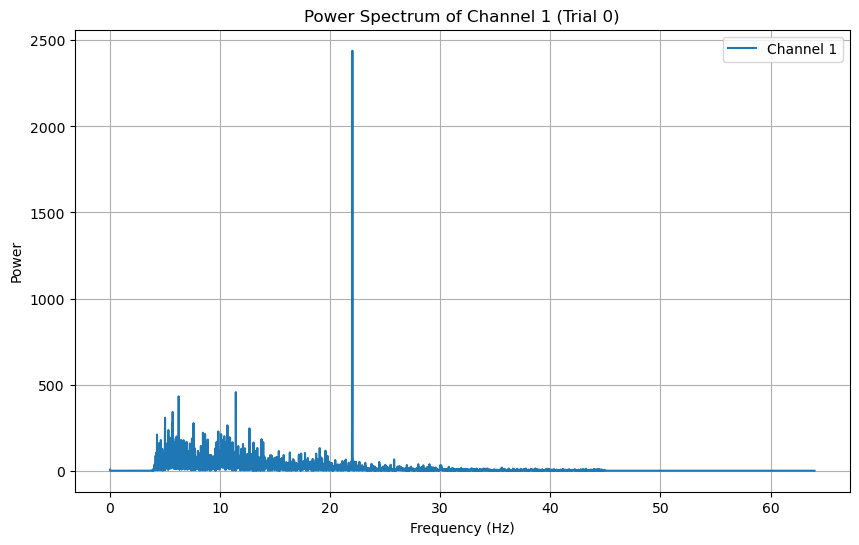

In [13]:
import matplotlib.pyplot as plt

# Plot the power spectrum for a specific channel (e.g., Channel 1)
plt.figure(figsize=(10, 6))
plt.plot(frequencies, power_spectrum[0], label='Channel 1')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectrum of Channel 1 (Trial 0)")
plt.legend()
plt.grid()
plt.show()

In [3]:
import numpy as np
import pandas as pd

# Extract data and labels
data = x['data']  # Shape: (40, 40, 8064)
labels = x['labels']  # Shape: (40, 4)

# Convert the labels array into a DataFrame
labels_df = pd.DataFrame(labels, columns=['Valence', 'Arousal', 'Dominance', 'Liking'])

# Convert a specific trial's first 32 channels to a DataFrame
trial_0_data = data[0, :32, :]  # Shape: (32, 8064) - First 32 channels of trial 0
trial_0_df = pd.DataFrame(trial_0_data)

# Compute the FFT for each channel in trial 0
sampling_rate = 512  # Hz, adjust to your actual sampling rate
n_timepoints = trial_0_data.shape[1]

# Compute the frequency bins
frequencies = np.fft.rfftfreq(n_timepoints, d=1/sampling_rate)

# Compute FFT for each channel
fft_result = np.fft.rfft(trial_0_data, axis=1)  # FFT along the time dimension

# Compute the power spectral density (PSD)
power_spectrum = np.abs(fft_result)**2 / n_timepoints

# Define the frequency bands (in Hz)
bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 40)
}

# Initialize a dictionary to store the band powers for each channel
band_powers = {band: [] for band in bands}

# Calculate the band power for each channel
for i, channel_data in enumerate(power_spectrum):
    band_power = {}
    for band, (low, high) in bands.items():
        # Find the frequency range indices
        band_indices = np.where((frequencies >= low) & (frequencies <= high))[0]
        # Compute the power in the band by summing the relevant frequencies
        band_power[band] = np.sum(channel_data[band_indices])
    # Store the band power for the current channel
    for band in bands:
        band_powers[band].append(band_power[band])

# Convert the band powers to a DataFrame for easy visualization
band_powers_df = pd.DataFrame(band_powers, index=[f"Channel {i+1}" for i in range(32)])

# Display the labels DataFrame
print("Labels Table:")
display(labels_df)

# Display the first trial's data as a table
print("Trial 0 (First 32 Channels, All Time Samples):")
display(trial_0_df)

# Display the power spectrum for each frequency band
print("Band Power of Trial 0 (First 32 Channels):")
display(band_powers_df)


Labels Table:


,Valence,Arousal,Dominance,Liking
0,7.71,7.60,6.90,7.83
1,8.10,7.31,7.28,8.47
2,8.58,7.54,9.00,7.08
3,4.94,6.01,6.12,8.06
4,6.96,3.92,7.19,6.05
5,8.27,3.92,7.00,8.03
6,7.44,3.73,7.08,7.04
7,7.32,2.55,6.32,5.87
8,4.04,3.29,3.62,5.99
9,1.99,4.86,2.04,7.09


Trial 0 (First 32 Channels, All Time Samples):


,0,1,2,3,4,5,6,7,8,9,...,8054,8055,8056,8057,8058,8059,8060,8061,8062,8063
0,0.948232,1.653335,3.013726,1.495061,-1.264836,-1.969558,-2.169066,-0.215480,3.326769,0.847765,...,0.226868,-0.872599,-0.251316,1.010068,3.845171,5.582611,2.171023,-2.826489,-4.477230,-3.676928
1,0.124707,1.390083,1.835099,-1.110738,-2.590622,-1.844258,-0.739794,2.395738,3.976389,0.002038,...,6.529591,4.566243,0.789426,-1.993420,0.317051,5.416049,4.085006,-2.987021,-6.287809,-4.474290
2,-2.216511,2.292017,2.746369,-2.364459,-2.309528,-0.668117,-0.837056,3.654975,6.369190,0.956049,...,4.705621,3.893851,2.738965,0.631252,2.163665,6.221588,4.290778,-2.637078,-7.406510,-6.755904
3,1.005734,1.297927,2.367689,-0.231850,-1.662444,-0.014568,0.736730,1.421469,0.419904,-2.287016,...,0.530650,2.947151,4.269418,3.324032,4.516819,4.856169,-0.038786,-4.582649,-4.403024,-1.373118
4,5.095919,5.000869,4.176166,0.354056,-4.154098,-3.980890,-0.553856,1.402554,-0.276699,-3.664428,...,0.817408,0.582459,2.267037,1.831632,0.616502,0.298991,-0.268494,-0.879462,-2.608805,-2.170391
5,1.206457,0.599485,0.869299,1.974166,-0.091352,-3.139610,-1.927116,1.206019,0.885561,-2.676358,...,3.811038,1.874436,-1.212466,-3.345520,-1.048931,1.976263,0.622648,-2.117416,-3.706191,-3.781734
6,3.866461,3.280028,0.656367,-3.077413,-2.857734,-0.102170,2.196924,3.132587,-0.000717,-1.864461,...,1.472198,0.555065,1.461479,0.492353,-0.387170,2.746697,2.022941,-3.322173,-4.181635,-1.693248
7,1.861664,7.190648,5.906498,-3.653504,-1.045527,3.617735,-0.447770,-0.260227,4.064688,7.247269,...,0.838495,2.258443,2.362836,3.639166,5.572698,-0.021492,-8.021583,-6.543766,-2.678091,-4.114859
8,3.689008,4.701009,1.712879,-4.312704,-4.377870,-1.607791,1.872628,5.128183,1.827594,0.735810,...,-0.443928,-1.901119,1.214977,1.354471,-1.010941,-0.269584,-1.091093,-3.102136,-1.968383,-0.748670
9,1.319819,-3.853227,-6.444708,-5.469621,-2.554392,0.958397,3.739551,3.442065,-0.344822,-1.052622,...,2.333256,0.673198,0.831126,-0.136575,-2.940629,-3.748632,-3.084615,-2.313458,-0.150341,2.683420


Band Power of Trial 0 (First 32 Channels):


,Delta,Theta,Alpha,Beta,Gamma
Channel 1,0.058890,0.208776,1.096623,15891.629034,8104.407337
Channel 2,0.257987,0.483926,1.467302,21676.004288,7937.722550
Channel 3,0.546919,0.991076,3.116771,25042.169246,8417.483385
Channel 4,0.023324,0.084538,0.662883,24544.181701,10379.375083
Channel 5,0.015865,0.073532,0.436688,12573.053363,6026.687979
Channel 6,0.958603,1.576299,3.622122,12395.443282,4752.042372
Channel 7,0.101318,0.236489,0.985496,13738.541151,7992.135948
Channel 8,0.802673,1.450532,4.598527,27383.148320,11668.980524
Channel 9,0.150796,0.249178,0.690690,10537.883030,9709.290930
Channel 10,0.260277,0.375206,0.637730,6194.047081,5171.327184
